#  Quora Questions Pairs 

## 1. Business Problems
### 1.1 Description
   Quora is a place to gain and share knowledge about anything. It's a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.10

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long

### Problem Statement :

1. Identify which questions asked on Quora are duplicates of questions that have already been asked.
   
2. This could be useful to instantly provide answers to questions that have already been answered.
   
3. We are tasked with predicting whether a pair of questions are duplicates or not.

### 1.2 Sources/ Useful links 
1. https://www.kaggle.com/c/quora-question-pairs 
2. https://www.kaggle.com/c/quora-question-pairs/discussion

### 1.3  Real world/Business Objectives and Constraints :
   - The cost of a mis-classification can be very high.
   - You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
   - No strict latency concerns.
   - Interpretability is partially important.

## 2. Machine Learning Problem 
### 2.1 Data 
#### 2.1.1 Data Overview 


Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate.

 Total we have 404290 entries..

### 2.1.2 Example Data Point :
"id", "gidl", "qid2", "questionl", "question2", "is_duplicate"


"0", "1","2", "What is the step by step guide to invest in share mark et in india?", "What is the step by step guide to invest in share ma rket?", "0"


"1","3", What is the story of Kohinoor (Kob 1-oor) Diamon d?", "Whaleuld happen if the indian government (10) le the Kohinoor (Koh-i-Noor) diamond back?", "0"


"7","15", "16", "How can I be a good geologist?", "What should I do to be a great geologist?", "1"


"11","23", "24", "How do I read and find my YouTube comments?", "How c an I see all my Youtube comments?","1"

## 2.2 Mapping the real world problem to an ML problem 

### 2.2.1  Type of Machine Learning Problem 
it is a binary classification problem , for a given pair of uestions we need to predict if they are duplicate or not 

### 2.2.2 Performance Metric 

- log-loss 
- Binary Confusion Matrix

## 2.3 Train and Test construction 
we build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with 

# 3. Exploratory Data Analysis 


In [5]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nltk
from collections import Counter 

from matplotlib import rcParams
import plotly.express as px

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import collections
%matplotlib inline

## 3.1 Reading data and basic stats 

In [6]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [7]:
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### 3.2.1 Distribution of data points among output classes 

<Axes: xlabel='is_duplicate'>

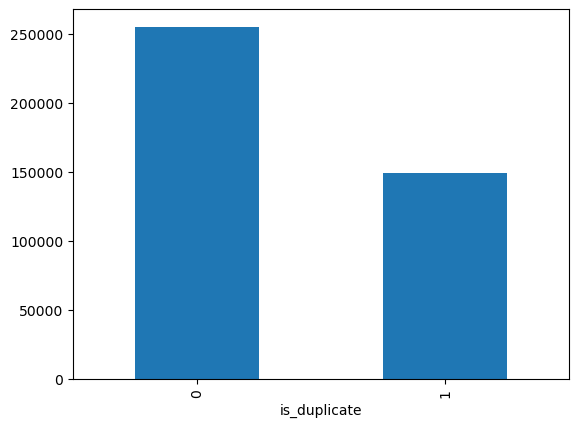

In [9]:
# Checking if we have imbalance data or not
df.groupby("is_duplicate")['id'].count().plot.bar()

In [10]:
unique=len(set(list(df['qid1'])+list(df['qid2'])))
print ('Total number of  Unique Questions are: {}\n'.format(unique))

Total number of  Unique Questions are: 537933



In [11]:
print('-->> Question pairs are not Similar (is_duplicate = 0):\n     {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('-->> Question pairs are Similar (is_duplicate = 1):\n     {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

-->> Question pairs are not Similar (is_duplicate = 0):
     63.08%
-->> Question pairs are Similar (is_duplicate = 1):
     36.92%


### 3.2.2 Number of unique questions

In [12]:
qids = pd.Series(list(df['qid1']) + list(df['qid2'])) #Creating a dataframe that contains the question id of both quid1 and quid2
unique_qs = len(np.unique(qids))  #Numpy array to filter down all qniue elements
qs_morethan_onetime = np.sum(qids.value_counts() > 1)   # Counts any question that have been repeated more than one time
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#len(set(list(df['qid1'])+list(df['qid2'])))


print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,round(qs_morethan_onetime/unique_qs*100,2)))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) # Taking the frequency of all question and printing the max of them

q_vals=qids.value_counts()
print(q_vals)


Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Name: count, Length: 537933, dtype: int64


### 3.2.3 Checking for duplicates 

In [15]:
#checking whether there are any repeated pair of questions

pair_duplicates= df[df.duplicated(['qid1','qid2'])]   # Collecting all Duplicate data into a dataframe so than we can also see what duplicate value we have

print ("Number of duplicate questions : ",pair_duplicates.shape[0])

Number of duplicate questions :  0


### 3.2.4 Number of occurance of each question

Maximum number of times a single question is repeated: 157



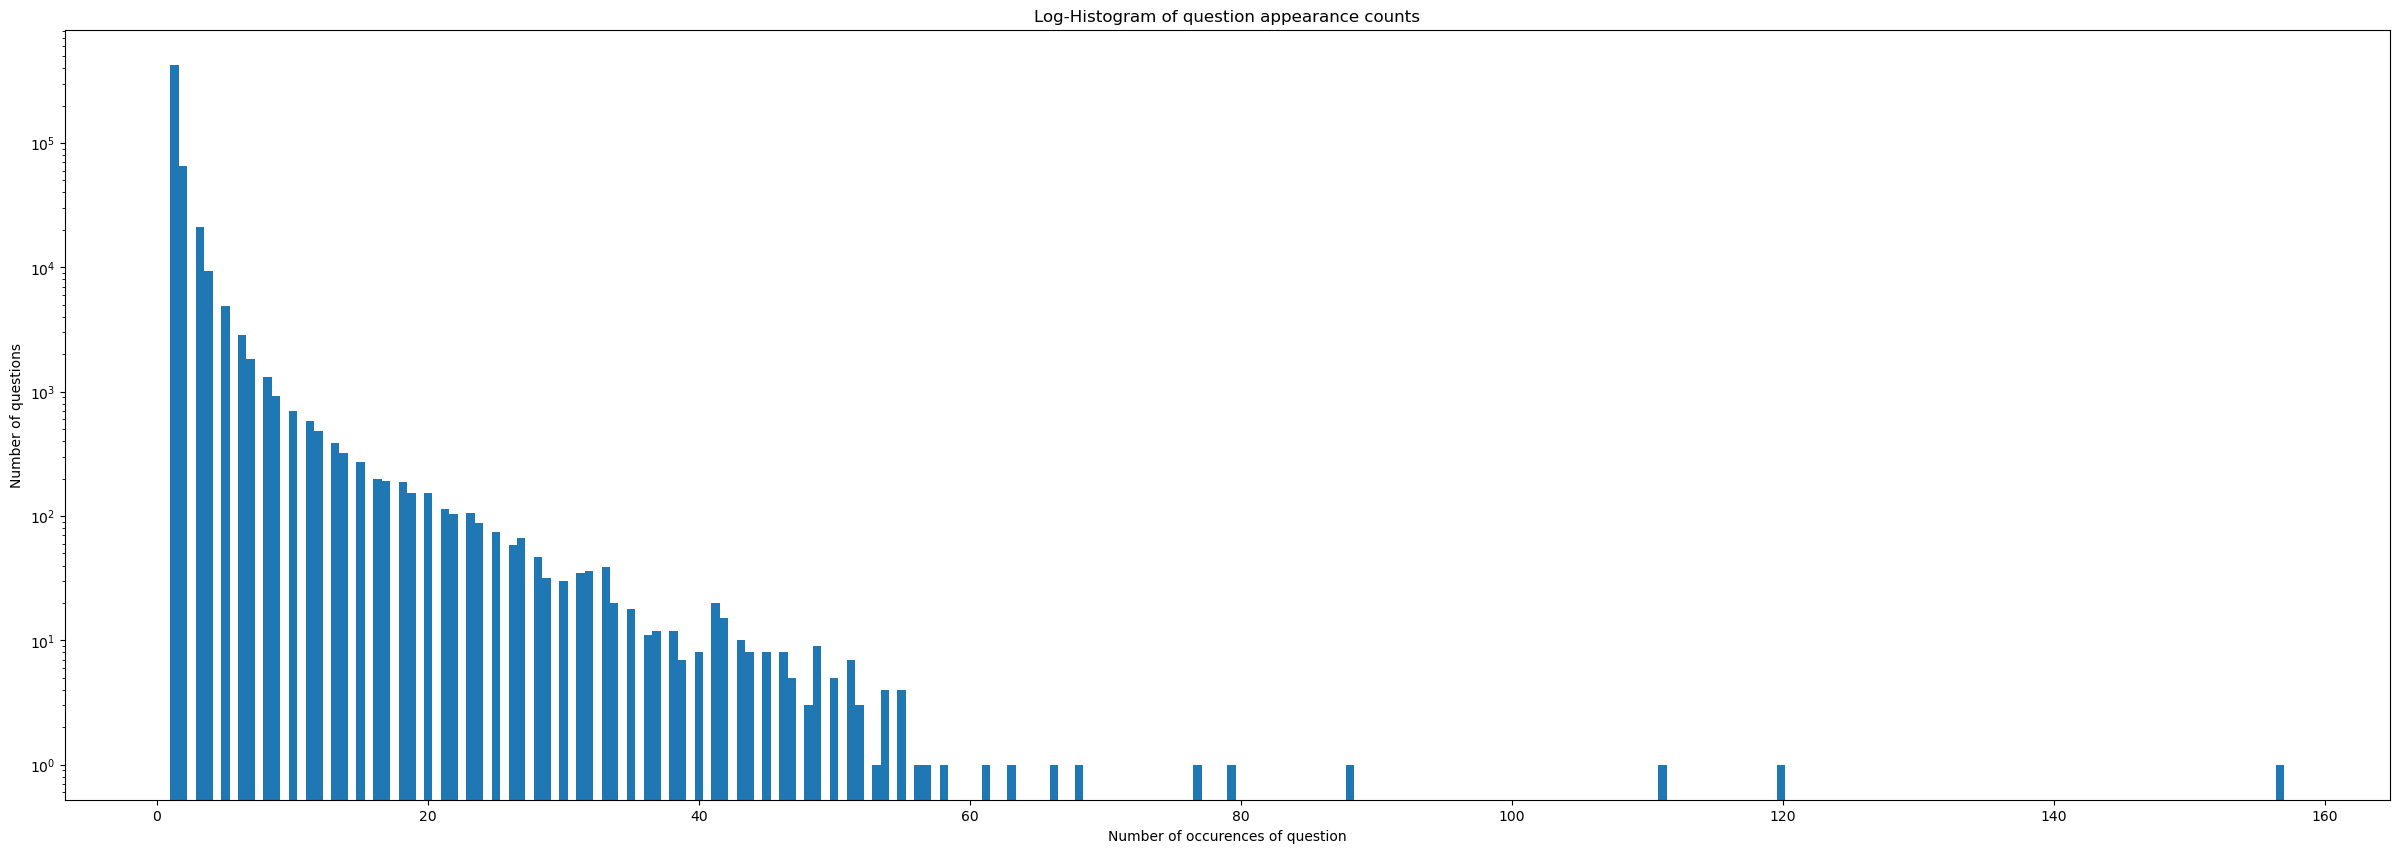

In [18]:
plt.figure(figsize=(30, 10))

plt.hist(qids.value_counts(), bins=250)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

### 3.2.5 checking for NULL values 

In [23]:
 # Checking if any value is null in our dataset
nan_rows = df[df.isnull().any(axis=1)] 
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [24]:
df.dropna(inplace=True)  # Droping Null Value
df[df.isnull().any(axis=1)] 

,id,qid1,qid2,question1,question2,is_duplicate


In [25]:
df['Q1_Len']=df['question1'].str.len()  # Finding length of Question 1
df['Q2_Len']=df['question2'].str.len()  # Finding length of Question 2

df['Q1_Words']=df['question1'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 1
df['Q2_Words']=df['question2'].apply(lambda row : len(row.split()))   # Finding Number of Words in Question 2

# Fucntion to find the number of common words in Question 1 and Question 2

def common(row):
    '''
    We are converting both Question 1 and Question 2 to set (and also converting them to lower so that every word have same) and finding there intersection so that we can get common words
    Then we are simply finding the lenth of those common words
    '''
    return len((set(row['question1'].lower().split())).intersection(set(row['question2'].lower().split())))


# Creating New Column with Number of Common Words
df['common_Word'] = df.apply(common, axis=1)


# Total Number of Distict words in both question1 and question2

def total(row):
    '''
    Coverting them to lower form then removing extra spaces and them removing the repeted words by converting them to sets 
    Then finding Length of Both the questions and adding them to find total words in both
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

# Getting total number of (unique) words in both question1 and question2
df['word_Total'] = df.apply(total, axis=1)


def word_share(row):
    '''
    Here we are finding total number of shared word and dividing by total number of words [ (A intersection B)/A+B]
    '''
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))    # Finding the number of common words between question1 and question2 and dividing by total words between both of them
df['Shared_Word'] = df.apply(word_share, axis=1)


# Saving our dataframe as csv file
df.to_csv("With_Feature.csv", index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1_Len,Q2_Len,Q1_Words,Q2_Words,common_Word,word_Total,Shared_Word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,10,23,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,4,20,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,4,24,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,2,20,0.100000


In [26]:
print ("Minimum length of the questions in question1 : " , min(df['Q1_Words']))
print ("Minimum length of the questions in question2 : " , min(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']== 1].shape[0])

print ("Maximum length of the questions in question1 : " , max(df['Q1_Words']))
print ("Maximum length of the questions in question2 : " , max(df['Q2_Words']))

print ("Number of Questions with minimum length [question1] :", df[df['Q1_Words']>120].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['Q2_Words']> 230].shape[0])

print ("Maximum number of Common word : " , max(df['common_Word']))
print ("Maximum number of Shared Word : " , max(df['Shared_Word']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 69
Number of Questions with minimum length [question2] : 25
Maximum length of the questions in question1 :  125
Maximum length of the questions in question2 :  237
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 13
Maximum number of Common word :  41
Maximum number of Shared Word :  0.5


#### Shared_Word

C:\Users\dines\AppData\Local\Temp\ipykernel_16588\3756169595.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\dines\AppData\Local\Temp\ipykernel_16588\3756169595.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




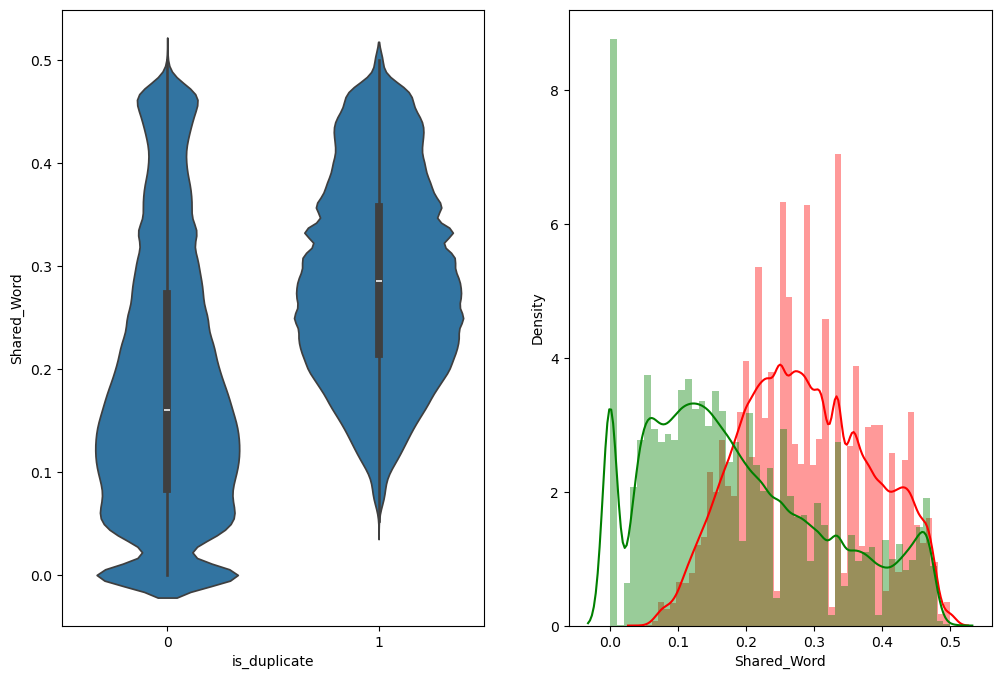

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'Shared_Word', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['Shared_Word'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['Shared_Word'][0:] , label = "0" , color = 'green' )
plt.show()

#### common_Word

C:\Users\dines\AppData\Local\Temp\ipykernel_16588\1370264901.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\dines\AppData\Local\Temp\ipykernel_16588\1370264901.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




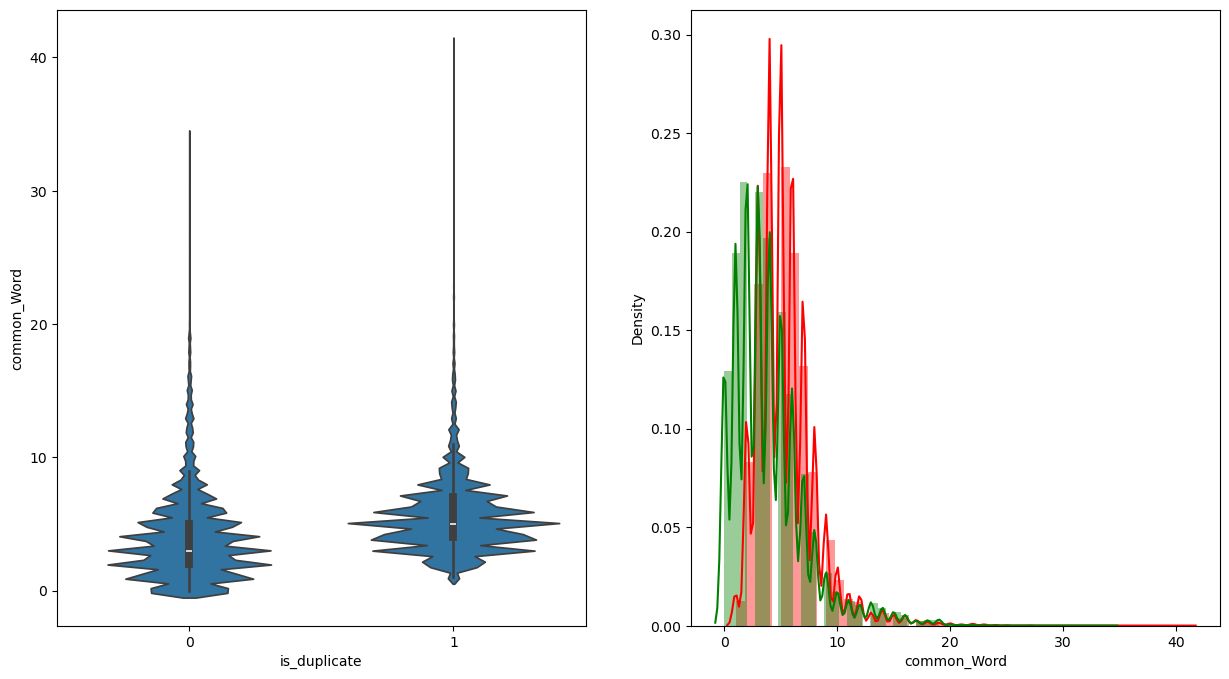

In [28]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'common_Word', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_Word'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_Word'][0:] , label = "0" , color = 'green' )
plt.show()

#### word_Total

C:\Users\dines\AppData\Local\Temp\ipykernel_16588\809395749.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\dines\AppData\Local\Temp\ipykernel_16588\809395749.py:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




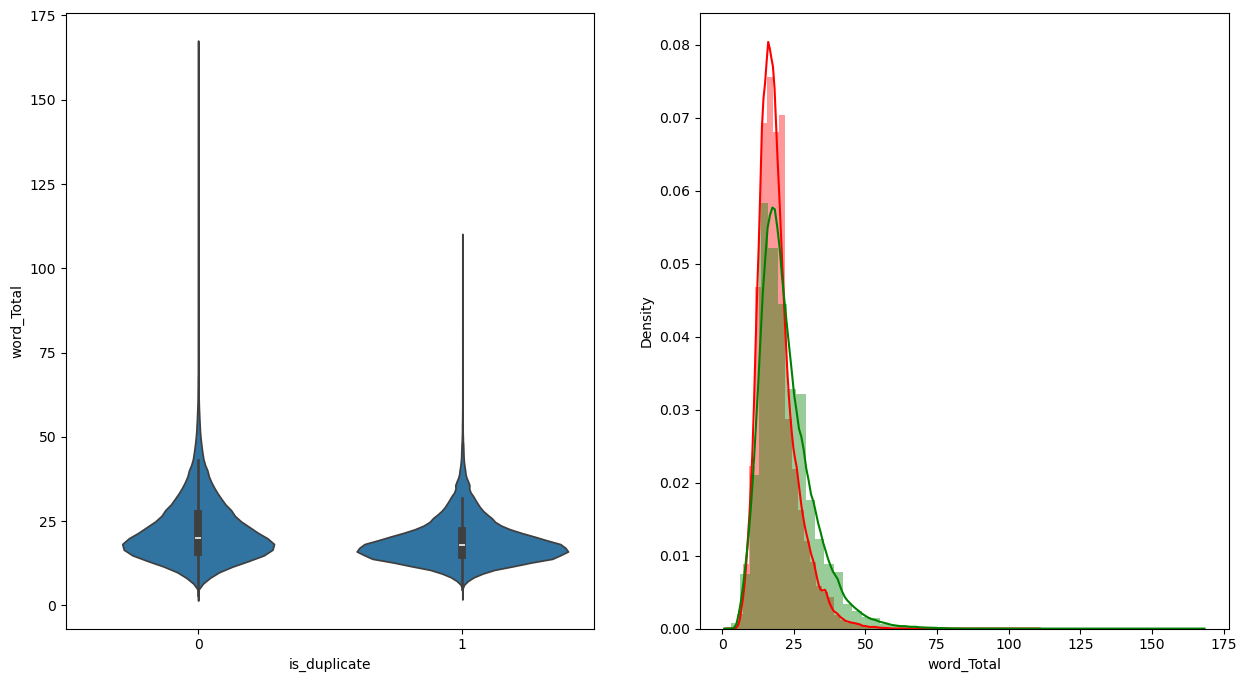

In [29]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Total', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Total'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Total'][0:] , label = "0" , color = 'green' )
plt.show()

###  TExt preprocessing 

In [30]:
from nltk.stem import SnowballStemmer
snow=nltk.stem.SnowballStemmer('english')

# Creating custom stopwords

stopwords= set(['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [31]:
def removeStopWord(word):
  token=word.split(" ")   ## coverting string to token (list of word) \\ like ["this","is","token"]
  removestop=[snow.stem(x) for x in token if x not in stopwords]   ##removing stopwords and also doing Stemming
  removed=" ".join(removestop)  ##joing back the list into sentence
  return removed

In [33]:
def preprocess(x):
    x = str(x).lower()  # Lowering all text to covert all of them to there base form
    
    # Replacing commonly use words or numbers like 1,000 to 1k and 1,000,000 to 1m and currency symbol to there respective names and many other symbols to there name
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " is")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("@","at")
    
    # Renaming 1000 to 1k and 1000000 to 1m (the onces which may not be seperated with commans)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    #Remove any special character like [= , ' ; "" ']
    
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    #Removing Stopwords And Doing Stemming
    x=removeStopWord(x)          
    
    return x

<>:21: SyntaxWarning:

invalid escape sequence '\W'

<>:21: SyntaxWarning:

invalid escape sequence '\W'

C:\Users\dines\AppData\Local\Temp\ipykernel_16588\2599246679.py:21: SyntaxWarning:

invalid escape sequence '\W'



In [34]:
# Doing Pre-processing on both question1 and question2

df['cleanQ1']=df['question1'].apply(preprocess)
df['cleanQ2']=df['question2'].apply(preprocess)

In [35]:
print('Questions 1 without pre-processing')
print(df['question1'][2])
print()
print('Questions 1 after pre-processing')
print(df['cleanQ1'][2])
print()
print('Questions 2 without pre-processing')
print(df['question2'][2])
print()
print('Questions 2 after pre-processing')
print(df['cleanQ2'][2])


Questions 1 without pre-processing
How can I increase the speed of my internet connection while using a VPN?

Questions 1 after pre-processing
how increas speed internet connect use vpn 

Questions 2 without pre-processing
How can Internet speed be increased by hacking through DNS?

Questions 2 after pre-processing
how internet speed increas hack dns 
